In [1]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
from helpers import *

# Data prep

Läs in fil

In [3]:
df = pd.read_csv('../indata/ODB_TSV/ODB-Sysselsättning efter område, tid, ålder, sysselsättning och kön.txt', sep='\t', header=1)

Specificera indexering

In [4]:
df = df.set_index(['område', 'tid'])

Vänd ner samtliga kolumner i en kolumn

In [5]:
df = pd.DataFrame(df.stack())

Lyft ut index till kolumner igen

In [6]:
df = df.reset_index()

Sätt beskrivande kolumnnamn

In [7]:
df = df.rename(columns={'level_2': 'age_group_gender', 0: 'value', 'tid':'year'})

Splitta områdesnamn till endast baskod

In [8]:
df['område'] = df['område'].str.split(' ', 1, expand = True)
df = df.rename(columns={'område': 'BASKOD2010'})
df['BASKOD2010'] = df['BASKOD2010'].astype(str).astype(int)

Byt om `BASKOD2010` till entity-namnet

In [9]:
df = baskod2010tobasomrade(df)

Splitta ut `ageyeargender` till fyra separata kolumner

In [10]:
df['Kön'] = df['age_group_gender'].str.split().str[-1]

In [11]:
df['agegroup'] = df['age_group_gender'].str.split().str[0]

In [12]:
df['kategori'] = df['age_group_gender'].str.split().str[2:-1].str.join(' ')

Specificera ordningen på kolumnerna

In [13]:
df = df[['basomrade','year','kategori', 'Kön', 'agegroup', 'value']]

Specificera indexering

In [14]:
df = df.set_index(['basomrade'])

In [15]:
df = df.groupby(['basomrade', 'year', 'kategori', 'Kön']).sum().reset_index()

Sätt `Kön` till en pandas category

In [16]:
df['Kön'] = df['Kön'].astype('category')
df['Kön'].cat.categories = ['female', 'male']

# Antal förvärvsarbetande

In [17]:
concept = 'employed_aged_20_64'

In [18]:
nSys = df[df['kategori'].isin(['Förvärvsarbetande ej län 01', 'Förvärvsarbetande län 01'])]

In [19]:
nSysGender = nSys.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()

In [20]:
male, female = byGender(concept, nSysGender)

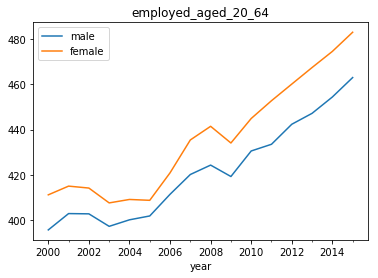

In [21]:
plotcombined(male, 'male', concept)
plotcombined(female, 'female')

In [22]:
nSys = nSys.groupby(['basomrade', 'year']).sum().reset_index()

In [23]:
total = appendNewDatapoints(concept, nSys)

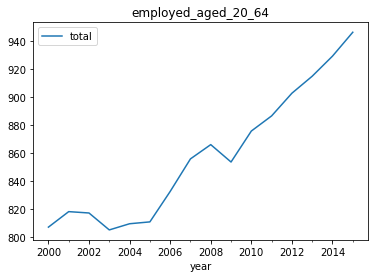

In [24]:
plotcombined(total, 'total', concept)

# Antal ej förvärvsarbetande

In [46]:
concept = 'unemployed_aged_20_64'

In [47]:
nNonSys = df[df['kategori'] == 'Ej Förvärvsarbetande']

In [48]:
nNonSysGender = nNonSys.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()

In [49]:
male, female = byGender(concept, nNonSysGender)

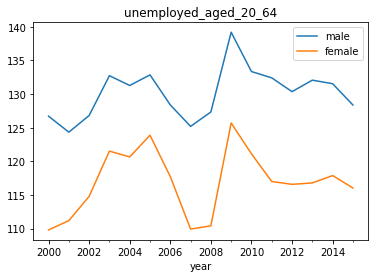

In [50]:
plotcombined(male, 'male', concept)
plotcombined(female, 'female')

In [52]:
nNonSys = nNonSys.groupby(['basomrade', 'year']).sum().reset_index()

In [53]:
total = appendNewDatapoints(concept, nNonSys)

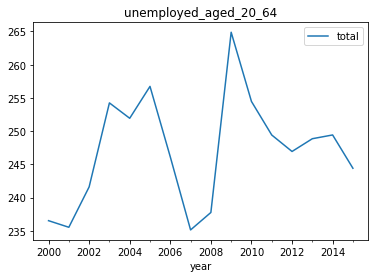

In [54]:
plotcombined(total, 'total', concept)

# Andel förvärvsarbetande

In [56]:
concept = 'employment_rate_20_64' #förvärvsarbetande

### Andel per kön

In [57]:
total = df.groupby(['basomrade', 'year', 'Kön']).sum().add_prefix('total_').reset_index()
# total = pd.merge(bygender, df)

In [58]:
bygender = df[df['kategori'].isin(['Förvärvsarbetande ej län 01', 'Förvärvsarbetande län 01'])]
bygender = bygender.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()

In [59]:
bygender = pd.merge(total, bygender)

In [60]:
bygender['rate'] = bygender['value'] / bygender['total_value']

In [61]:
bygender = bygender[['basomrade', 'year', 'Kön', 'rate']]
bygender = bygender.rename(columns={'rate': 'value'})

In [62]:
female, male = byGender(concept, bygender)

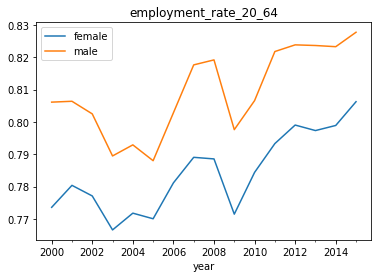

In [63]:
plotcombined(female, 'female', concept)
plotcombined(male, 'male')

### Andel totalt

In [64]:
total = df.groupby(['basomrade', 'year']).sum().add_prefix('total_').reset_index()

In [65]:
rate = df[df['kategori'].isin(['Förvärvsarbetande ej län 01', 'Förvärvsarbetande län 01'])]
rate = rate.groupby(['basomrade', 'year']).sum().reset_index()

In [66]:
rate = pd.merge(total, rate)

In [67]:
rate['rate'] = rate['value'] / rate['total_value']

In [68]:
rate = rate[['basomrade', 'year', 'rate']]
rate = rate.rename(columns={'rate': 'value'})

In [69]:
total = appendNewDatapoints(concept, rate)

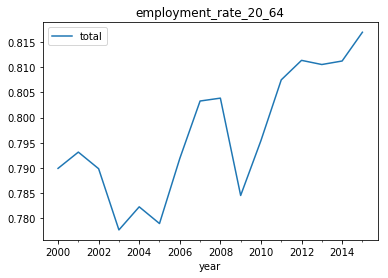

In [70]:
plotcombined(total, 'total', concept)